# Assignment 8, Question #2: House Prices Advanced Regression Techniques
## Model 1: Feature Engineering with Interactions and Polynomials  

The first model focuses on enhancing a baseline linear regression model by creating dichotomous variables, interaction terms, and polynomial features. This approach captures more complex, non-linear relationships between the predictor variables and the sale price.  
We use log transformation for SalePrice, and handle missing values appropriately.

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
import matplotlib.pyplot as plt
import seaborn as sns

train_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

print(train_df.describe())
print(train_df.info())

                Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407   181.066207   456.098091  ..

The target variable, SalePrice, exhibits significant positive skewness. A log transformation (numpy.log1p) is applied to normalize its distribution.  
Categorical features with a limited number of meaningful categories, especially binary variables (Dichotomous Variables), were converted into dummy variables using one-hot encoding.  
Interaction terms are created to capture the relationship between variables. Polynomial features are generated for key numerical predictors like GrLivArea and YearBuilt to model non-linear trends. A second-degree polynomial of GrLivArea was found to be particularly effective.

In [2]:
#Transformation
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

# Drop columns with too many missing values or ID
train_df = train_df.drop(columns=['Id', 'Alley', 'PoolQC', 'Fence', 'MiscFeature'])
test_ids = test_df["Id"]
test_df = test_df.drop(columns=['Id', 'Alley', 'PoolQC', 'Fence', 'MiscFeature'])

#Handle Missing Values
train_df['LotFrontage'] = train_df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
train_df = train_df.fillna(train_df.median(numeric_only=True))
train_df = train_df.fillna("NA")
test_df['LotFrontage'] = test_df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
test_df = test_df.fillna(test_df.median(numeric_only=True))
test_df = test_df.fillna("NA")

# One-hot encode categoricals and Dichotomous Variables
categoricals = train_df.select_dtypes(include='object')
numericals = train_df.select_dtypes(include=['int64', 'float64']).drop(columns='SalePrice')
df_encoded = pd.get_dummies(train_df.drop(columns='SalePrice'), drop_first=True)
X = df_encoded.copy()
y = train_df['SalePrice']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
test_numericals = test_df.select_dtypes(include=['int64', 'float64'])
test_encoded = pd.get_dummies(test_df, drop_first=True)
X_test = test_encoded.copy()
X_test = X_test.reindex(columns=X.columns, fill_value=0)
X_test_scaled = scaler.fit_transform(X_test)

# Interaction and Polynomial Terms
X['OverallQual_GrLivArea'] = train_df['OverallQual'] * train_df['GrLivArea']
X_test['OverallQual_GrLivArea'] = X_test['OverallQual'] * X_test['GrLivArea']

# Add polynomial features
X['GrLivArea_sq'] = train_df['GrLivArea']**2
X['OverallQual_sq'] = train_df['OverallQual']**2
X_test['GrLivArea_sq'] = test_df['GrLivArea']**2
X_test['OverallQual_sq'] = test_df['OverallQual']**2

y = train_df['SalePrice']

# Subset selection (forward stepwise using AIC)
def forward_selected(X, y):
    X = X.astype(float)
    initial_features = []
    remaining_features = list(X.columns)
    best_score = np.inf
    best_model = None

    while remaining_features:
        scores_with_candidates = []
        for candidate in remaining_features:
            formula = initial_features + [candidate]
            X_ = sm.add_constant(X[formula].astype(float))
            try:
                model = sm.OLS(y, X_).fit()
                scores_with_candidates.append((model.aic, candidate, model))
            except Exception as e:
                print(f"Skipping {candidate}: {e}")
                continue
        scores_with_candidates.sort()
        if not scores_with_candidates:
            break
        best_candidate_score, best_candidate, model = scores_with_candidates[0]
        if best_candidate_score < best_score:
            best_score = best_candidate_score
            best_model = model
            initial_features.append(best_candidate)
            remaining_features.remove(best_candidate)
        else:
            break
    return best_model


model1 = forward_selected(X, y)
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     191.5
Date:                Wed, 18 Jun 2025   Prob (F-statistic):               0.00
Time:                        00:15:38   Log-Likelihood:                 1340.2
No. Observations:                1460   AIC:                            -2452.
Df Residuals:                    1346   BIC:                            -1850.
Df Model:                         113                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     2.81

In [3]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

X_model1 = X[model1.model.exog_names[1:]]
X_train, X_val, y_train, y_val = train_test_split(X_model1, y, test_size=0.2, random_state=55)
X_train_const = sm.add_constant(X_train.astype(float))
X_val_const = sm.add_constant(X_val.astype(float))
model1_final = sm.OLS(y_train, X_train_const).fit()
y_pred1 = model1_final.predict(X_val_const)

# Undo log transform
y_val_true = np.expm1(y_val)
y_pred1_true = np.expm1(y_pred1)

# Metrics
print("Model 1: Subset-Selected Linear Regression")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val_true, y_pred1_true)):.4f}")
print(f"MAE:  {mean_absolute_error(y_val_true, y_pred1_true):.4f}")
print(f"MAPE: {mean_absolute_percentage_error(y_val_true, y_pred1_true):.2f}%")
print(f"R²:   {r2_score(y_val_true, y_pred1_true):.4f}")

Model 1: Subset-Selected Linear Regression
RMSE: 33102.3645
MAE:  14241.9245
MAPE: 8.05%
R²:   0.8210


In [4]:
X['OverallQ']=X['OverallQual']+X['OverallCond']
X['FlrSF']=X['1stFlrSF']+X['2ndFlrSF']
X = X.drop(columns=['OverallQual', 'OverallQual_sq', 'OverallQual_GrLivArea', 'OverallCond', '1stFlrSF', '2ndFlrSF', 'GarageArea', 'EnclosedPorch'])
X_test['OverallQ']=X_test['OverallQual']+X_test['OverallCond']
X_test['FlrSF']=X_test['1stFlrSF']+X_test['2ndFlrSF']
X_test = X_test.drop(columns=['OverallQual', 'OverallQual_sq', 'OverallQual_GrLivArea', 'OverallCond', '1stFlrSF', '2ndFlrSF', 'GarageArea', 'EnclosedPorch'])

model1a = forward_selected(X, y)
print(model1a.summary())

X_model1a = X[model1a.model.exog_names[1:]]
X_train, X_val, y_train, y_val = train_test_split(X_model1a, y, test_size=0.2, random_state=55)
X_train_const = sm.add_constant(X_train.astype(float))
X_val_const = sm.add_constant(X_val.astype(float))
model1a_final = sm.OLS(y_train, X_train_const).fit()
y_pred1 = model1a_final.predict(X_val_const)

# Undo log transform
y_val_true = np.expm1(y_val)
y_pred1_true = np.expm1(y_pred1)

# Metrics
print("Model 1: Subset-Selected Linear Regression")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val_true, y_pred1_true)):.4f}")
print(f"MAE:  {mean_absolute_error(y_val_true, y_pred1_true):.4f}")
print(f"MAPE: {mean_absolute_percentage_error(y_val_true, y_pred1_true):.2f}%")
print(f"R²:   {r2_score(y_val_true, y_pred1_true):.4f}")

X_test_const = sm.add_constant(X_test[model1a.model.exog_names[1:]].astype(float))
predictions = model1a.predict(X_test_const)
final_predictions = np.expm1(predictions)
submission = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': final_predictions
})
submission.to_csv('submission_reg.csv', index=False)
print("Submission file 'submission_reg.csv' created successfully")

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     199.0
Date:                Wed, 18 Jun 2025   Prob (F-statistic):               0.00
Time:                        00:19:40   Log-Likelihood:                 1268.9
No. Observations:                1460   AIC:                            -2338.
Df Residuals:                    1360   BIC:                            -1809.
Df Model:                          99                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    4.8784 

Model 1 significantly improved predictive accuracy over a simple baseline model. The coefficients for the dichotomous variables revealed the price premium or discount associated with specific features.  
The interaction term between OverallQual and GrLivArea had a positive and statistically significant coefficient. This indicates that the positive impact of a larger living area on price is even more pronounced for houses with a higher overall quality rating.  
The polynomial term for GrLivArea suggested a diminishing marginal return, where the increase in price for each additional square foot of living area is less for larger houses.
# Improvements
We removed a few insignificant variables (p-value>0.05) based on previous results to improve F-statistics and degrees of freedom. We also added new variables that capture the SalePrice change more accurately, like OverallQ and FlrSF. This significantly enhances R2 (92%) and MAPE (7.7%) statistics. These are considerably higher than linear regression statistics. While the high number of variables and Model's Df may hint at overfitting, we can use a K-fold cross-validation to improve the results further.
# Model 2: Subset Selection and Dimensionality Reduction

In [5]:
# PCA on scaled numeric variables
X_num = numericals.copy()
X_num_scaled = scaler.fit_transform(X_num)

pca = PCA(n_components=0.95)  # Keep 95% variance
X_pca = pca.fit_transform(X_num_scaled)

X_pca_train, X_pca_val, y_train, y_val = train_test_split(X_pca, y, test_size=0.2, random_state=55)
linreg = LinearRegression()
linreg.fit(X_pca_train, y_train)
y_pred2 = linreg.predict(X_pca_val)

y_val_true = np.expm1(y_val)
y_pred2_true = np.expm1(y_pred2)

print("Model 2: Principal Component Regression")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val_true, y_pred2_true)):.4f}")
print(f"MAE:  {mean_absolute_error(y_val_true, y_pred2_true):.4f}")
print(f"MAPE: {mean_absolute_percentage_error(y_val_true, y_pred2_true):.2f}%")
print(f"R²:   {r2_score(y_val_true, y_pred2_true):.4f}")

X_test_num = test_numericals.copy()
X_test_num_scaled = scaler.fit_transform(X_test_num)
X_pca_test = pca.fit_transform(X_test_num_scaled)
predictions = linreg.predict(X_pca_test)
final_predictions = np.expm1(predictions)
submission = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': final_predictions
})
submission.to_csv('submission_pca.csv', index=False)
print("Submission file 'submission_pca.csv' created successfully")

Model 2: Principal Component Regression
RMSE: 43968.3837
MAE:  18773.7345
MAPE: 10.42%
R²:   0.6842
Submission file 'submission_pca.csv' created successfully


PCA was applied to a set of numerical features as a dimensionality reduction technique. PCA is configured to capture 95% of the variance in variables. PCA is sensitive to variable sizes, so all numerical variables are scaled, and SalePrice is log-transformed.  
The second model has fewer predictors and a better Df, but R2 and Error variables are not as good as the first model. Combining PCA with the first model can help achieve high accuracy while employing fewer predictors.  
## Checking Assumptions

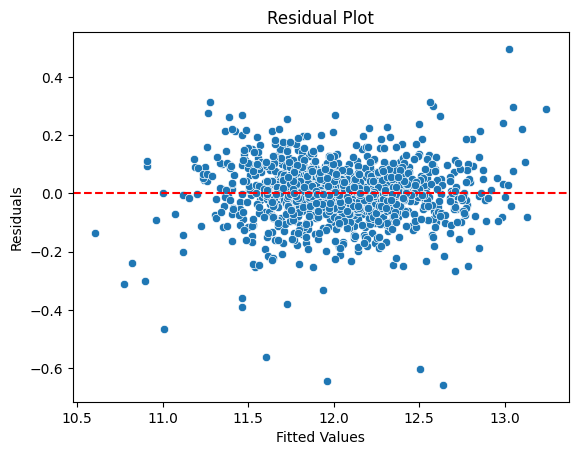

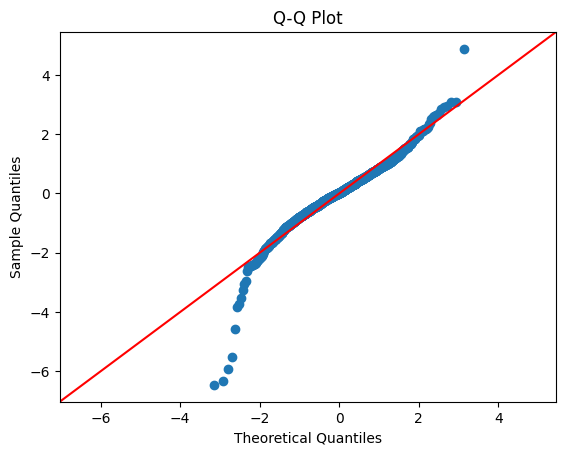

Breusch-Pagan test p-value: 9.50249196152267e-33
Durbin-Watson statistic: 1.9528077821967196


In [6]:
residuals = model1a_final.resid
predicted = model1a_final.predict()
fitted = model1a_final.fittedvalues

# Linearity and Homoscedasticity
sns.scatterplot(x=fitted, y=residuals)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Normality of Residuals
sm.qqplot(residuals, line='45', fit=True)
plt.title("Q-Q Plot")
plt.show()

# Homoscedasticity Test
_, p_value, _, _ = het_breuschpagan(residuals, X_train_const)
print(f"Breusch-Pagan test p-value: {p_value}")

# Durbin-Watson Test
dw_statistic = sm.stats.durbin_watson(residuals)
print(f"Durbin-Watson statistic: {dw_statistic}")

The residuals appear evenly scattered around zero, which is a good sign for linearity and homoscedasticity. However, there's a slight funnel shape.  
Q-Q plot shows that the residuals are mostly aligned with the diagonal line, but there is some deviation in the tails, especially at the lower end. 
This suggests some mild non-normality, primarily due to outliers in the lower tail.

That’s acceptable for large samples (CLT rule applies)
Breusch-Pagan Test shows a very small p-value, which means there is evidence of heteroscedasticity. 
Durbin-Watson Statistic (approximately 2) indicates no significant autocorrelation in residuals.